# Predict Bike Rental Data
Let's look at bike rental data from Washington DC. This data was previously compiled and processed from Hadi Fanaee-T at the University of Porto. The dataset can be found here:http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

Let's see if we can predict the number of riders for a given hour on a given day.


Here's a description of the columns included in the data.
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [36]:
bike_rentals = pd.read_csv('hour.csv')

In [37]:
bike_rentals.head(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [38]:
bike_rentals.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

Let's look at the distribution of the bike rental count.

In [39]:
bike_rentals.cnt.hist(bins=20)

Let's look to see how bike rentals correlate to the other columns:

In [40]:
corr = bike_rentals.corr()
corr['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It looks like there are correlations between the hour of the day, the temperature, and humidity (negative). Casual and registered columns don't matter because the rental count is derived from these.

Let's look at how the numerical columns look compared to the rentals. It's intersting to see that there is a negative correlation to holidays. Let's overlay holidays on the plots.

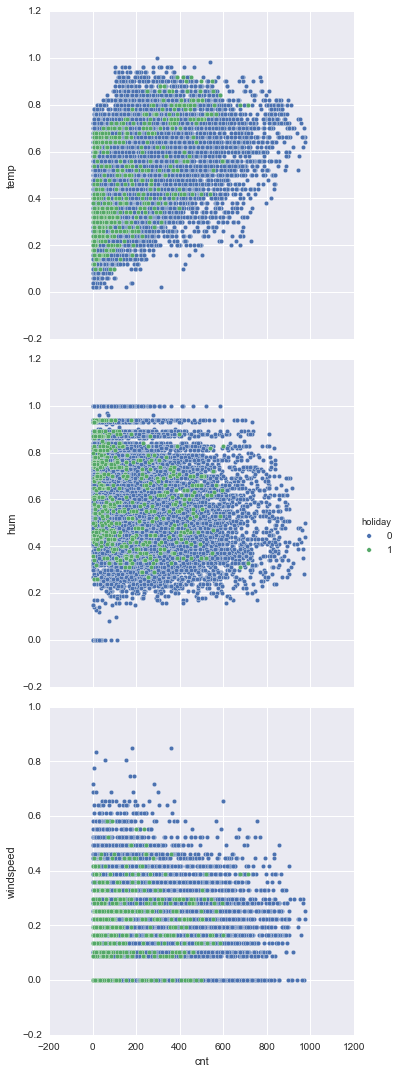

In [41]:
g = sns.pairplot(data=bike_rentals,x_vars=['cnt'], \
             y_vars=['temp','hum', 'windspeed'], size=5,hue='holiday')

Let's look at how `temp` and `atemp` compare to each other

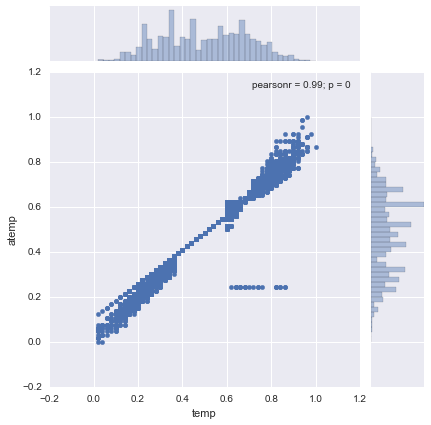

In [42]:
sns.jointplot(x=bike_rentals.temp,y=bike_rentals.atemp)

It looks like the adjusted temp is greater than the actual temperature at higher temps, and lower at lower temps. This is probably taking into account the humidity and wind speed to come up with what the temperature feels like. 

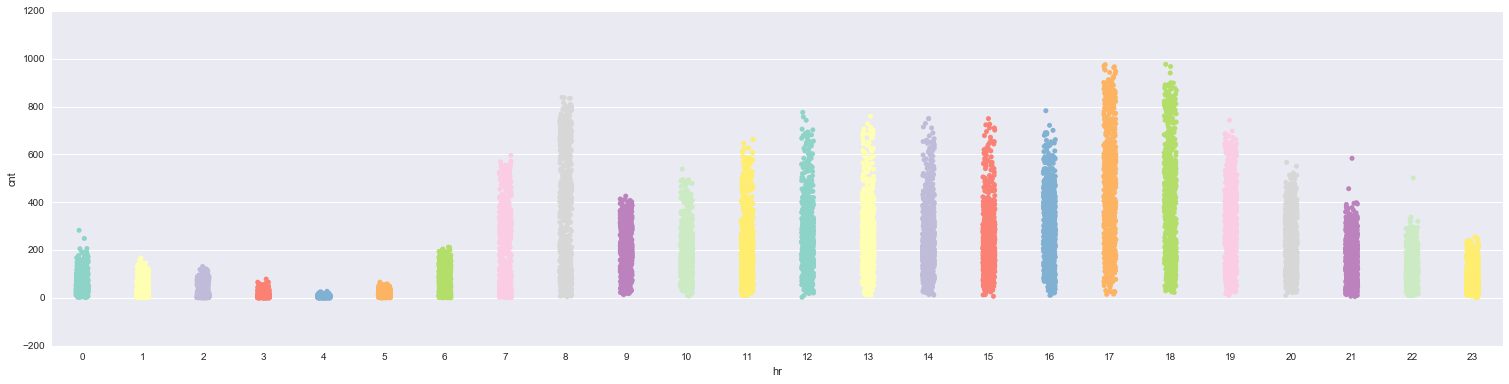

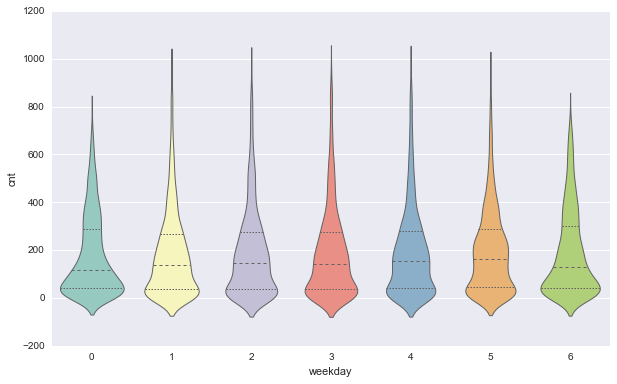

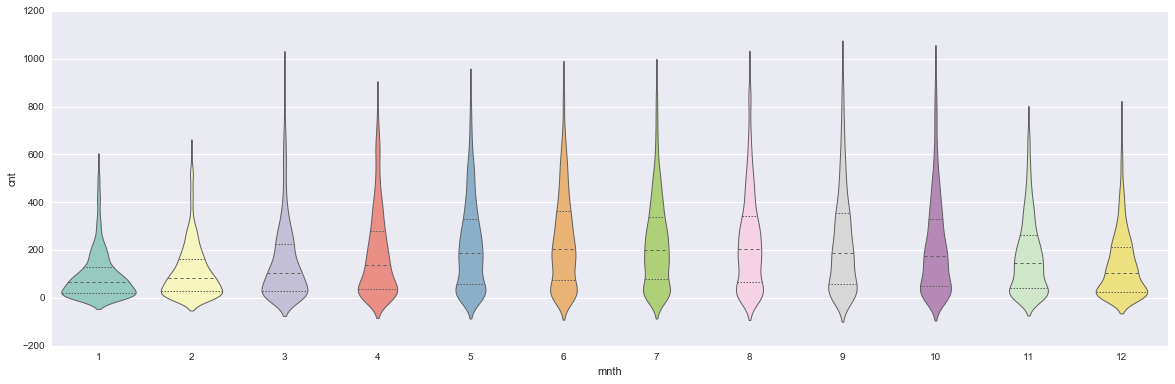

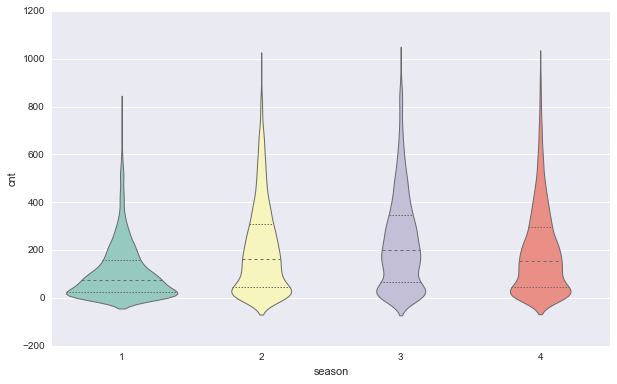

In [43]:
plt.figure(figsize=(26, 6))
sns.stripplot(data=bike_rentals,y='cnt',x='hr',palette="Set3",jitter=True)
plt.show()
plt.figure(figsize=(10, 6))
sns.violinplot(data=bike_rentals,y='cnt',x='weekday',palette="Set3", linewidth=1,inner="quartile")
plt.show()
plt.figure(figsize=(20, 6))
sns.violinplot(data=bike_rentals,y='cnt',x='mnth',palette="Set3", linewidth=1,inner="quartile")
plt.show()
plt.figure(figsize=(10, 6))
sns.violinplot(data=bike_rentals,y='cnt',x='season',palette="Set3", linewidth=1,inner="quartile")
plt.show()

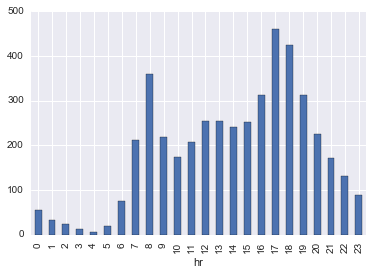

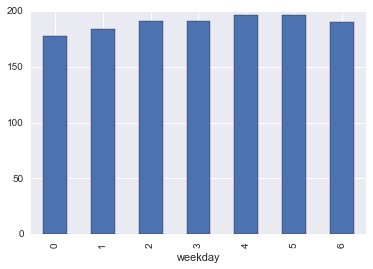

In [44]:
bike_rentals.groupby('hr').agg('mean')['cnt'].plot(kind='bar')
plt.show()
bike_rentals.groupby('weekday').agg('mean')['cnt'].plot(kind='bar')
plt.show()
bike_rentals.groupby('mnth').agg('mean')['cnt'].plot(kind='bar')
plt.show()
bike_rentals.groupby('season').agg('mean')['cnt'].plot(kind='bar')
plt.show()


In [45]:
sns.jointplot(data=bike_rentals,x='cnt',y='temp')

Let's look at how registered riders and casual riders compare to one another:

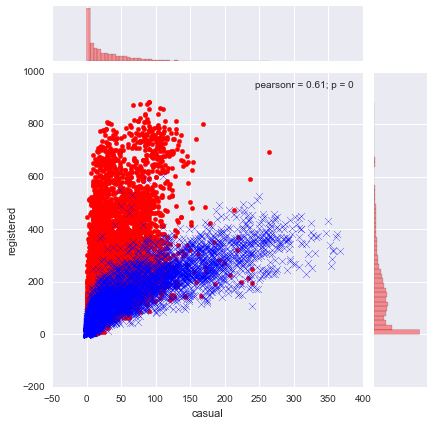

In [46]:
weekend = bike_rentals[bike_rentals.workingday!=1]
weekday = bike_rentals[bike_rentals.workingday==1]

graph = sns.jointplot(data=weekday,x='casual',y='registered',color='r')
graph.x = weekend.casual
graph.y = weekend.registered
graph.plot_joint(plt.scatter, marker='x', c='b', s=50)


It looks like theres a correlations between casual riders on the weekend, and registered riders on weekdays. Let's look in to this more.

In [47]:
bike_rentals[['workingday','casual','registered']].corr()

workingday    casual  registered
workingday    1.000000 -0.300942    0.134326
casual       -0.300942  1.000000    0.506618
registered    0.134326  0.506618    1.000000

## Variable Selection
Which variables do we want to use in our analysis? And what pre processing is required?

Let's drop the `instant` column since that is just a row label. Let's also drop `dteday` and `yr` since it isn't clear how it will help us. Let's also drop `season` since that data is duplicated in the `mnth` variable. And let's drop the `temp` variable since this is duplicated in the adjusted temp.

In [48]:
bike_rentals.drop(['instant','dteday','yr','season','temp'], inplace=True, axis=1)

In order to simplify the data, let's convert `hr` into 4 separate times of the day, and drop the `hr` variable.

In [49]:
def assign_label(hour):
    if hour < 6:
        val = 4
    elif hour < 12:
        val = 1
    elif hour < 18:
        val = 2
    else:
        val = 3
    return val
bike_rentals['time_label'] = bike_rentals.hr.apply(assign_label)
bike_rentals.drop(['hr'], inplace=True, axis=1)

## Category Variables

It looks like `season`, `hr`, `weekday`, and `weathersit` are categorical. So we will need to convert these to dummy variables. If we don't, our regression algorithm will think Friday is more important than Monday because it treats everything as numerical variables.

In [50]:
cat_cols = ['mnth','time_label','holiday','weekday','workingday','weathersit']
for col in cat_cols:
    bike_rentals[col] = bike_rentals[col].astype('category')
dummy_df = pd.get_dummies(bike_rentals[cat_cols])
bike_rentals = pd.concat([bike_rentals,dummy_df],axis=1)
bike_rentals.drop(cat_cols,inplace=True,axis=1)

In [51]:
bike_rentals.columns

Index(['atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'mnth_1',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'time_label_1',
       'time_label_2', 'time_label_3', 'time_label_4', 'holiday_0',
       'holiday_1', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'workingday_0', 'workingday_1',
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

Let's split the dataset into a training and test set:

In [52]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals[~bike_rentals.index.isin(train.index)]

Let's select which columns we'll use to predict the rental count:

In [53]:
columns = ['atemp', 'hum', 'windspeed', 'mnth_1',\
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',\
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'time_label_1',\
       'time_label_2', 'time_label_3', 'time_label_4', 'holiday_0',\
       'holiday_1', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',\
       'weekday_4', 'weekday_5', 'weekday_6', 'workingday_0', 'workingday_1',\
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4']

In [54]:
train[columns]

atemp   hum  windspeed  mnth_1  mnth_2  mnth_3  mnth_4  mnth_5  \
11259  0.4242  0.82     0.1045     0.0     0.0     0.0     1.0     0.0   
2649   0.5000  1.00     0.0896     0.0     0.0     0.0     1.0     0.0   
8555   0.3030  0.57     0.2537     0.0     0.0     0.0     0.0     0.0   
7340   0.4242  0.77     0.1045     0.0     0.0     0.0     0.0     0.0   
575    0.1818  0.86     0.2836     1.0     0.0     0.0     0.0     0.0   
8361   0.3788  0.53     0.0000     0.0     0.0     0.0     0.0     0.0   
9474   0.3333  0.61     0.1642     0.0     1.0     0.0     0.0     0.0   
17147  0.2273  0.44     0.4179     0.0     0.0     0.0     0.0     0.0   
2335   0.5152  0.68     0.1343     0.0     0.0     0.0     1.0     0.0   
9035   0.3030  0.81     0.2537     1.0     0.0     0.0     0.0     0.0   
5533   0.6364  0.34     0.1045     0.0     0.0     0.0     0.0     0.0   
12835  0.6515  0.51     0.0000     0.0     0.0     0.0     0.0     0.0   
10094  0.5455  0.32     0.2985     0.0     0.0     1.0     0.0     0.0   
1964   0.3333  0.34     0.0000     0.0     0.0     1.0     0.0     0.0   
16751  0.4242  0.35     0.4478     0.0     0.0     0.0     0.0     0.0   
10134  0.3788  0.93     0.0000     0.0     0.0     1.0     0.0     0.0   
11191  0.6364  0.57     0.2537     0.0     0.0     0.0     1.0     0.0   
9516   0.2727  0.70     0.1343     0.0     1.0     0.0     0.0     0.0   
4188   0.7424  0.49     0.1642     0.0     0.0     0.0     0.0     0.0   
16741  0.4394  0.58     0.2836     0.0     0.0     0.0     0.0     0.0   
14152  0.2424  0.69     0.2985     0.0     0.0     0.0     0.0     0.0   
16132  0.3485  0.71     0.1045     0.0     0.0     0.0     0.0     0.0   
10465  0.4242  0.94     0.0000     0.0     0.0     1.0     0.0     0.0   
12722  0.5758  0.78     0.1343     0.0     0.0     0.0     0.0     0.0   
16206  0.5000  0.83     0.2836     0.0     0.0     0.0     0.0     0.0   
7604   0.3030  0.36     0.1343     0.0     0.0     0.0     0.0     0.0   
16672  0.3182  0.81     0.1642     0.0     0.0     0.0     0.0     0.0   
9693   0.3030  0.42     0.1642     0.0     1.0     0.0     0.0     0.0   
16176  0.5000  0.45     0.1343     0.0     0.0     0.0     0.0     0.0   
3654   0.5303  0.94     0.1045     0.0     0.0     0.0     0.0     0.0   
...       ...   ...        ...     ...     ...     ...     ...     ...   
2646   0.5000  1.00     0.0000     0.0     0.0     0.0     1.0     0.0   
15436  0.5152  0.60     0.2836     0.0     0.0     0.0     0.0     0.0   
3014   0.6212  0.38     0.0000     0.0     0.0     0.0     0.0     1.0   
5649   0.6515  0.45     0.1045     0.0     0.0     0.0     0.0     0.0   
11834  0.5000  0.68     0.1642     0.0     0.0     0.0     0.0     1.0   
15868  0.4848  0.55     0.4179     0.0     0.0     0.0     0.0     0.0   
379    0.1818  0.50     0.1343     1.0     0.0     0.0     0.0     0.0   
16990  0.4091  0.50     0.2239     0.0     0.0     0.0     0.0     0.0   
5422   0.6061  0.83     0.1045     0.0     0.0     0.0     0.0     0.0   
16520  0.2576  0.69     0.0000     0.0     0.0     0.0     0.0     0.0   
7512   0.6212  0.44     0.3284     0.0     0.0     0.0     0.0     0.0   
10126  0.3636  0.93     0.0896     0.0     0.0     1.0     0.0     0.0   
10475  0.6212  0.53     0.0896     0.0     0.0     1.0     0.0     0.0   
9178   0.2121  0.86     0.1343     1.0     0.0     0.0     0.0     0.0   
2113   0.3030  0.61     0.2985     0.0     0.0     0.0     1.0     0.0   
12156  0.7121  0.52     0.2537     0.0     0.0     0.0     0.0     1.0   
16761  0.2121  0.55     0.2985     0.0     0.0     0.0     0.0     0.0   
7352   0.3636  0.87     0.0896     0.0     0.0     0.0     0.0     0.0   
586    0.1818  0.93     0.3582     1.0     0.0     0.0     0.0     0.0   
11512  0.5000  0.48     0.1343     0.0     0.0     0.0     1.0     0.0   
11413  0.5909  0.20     0.2836     0.0     0.0     0.0     1.0     0.0   
737    0.1667  0.43     0.2537     0.0     1.0     0.0     0.0     0.0   
10782  0.333

# Linear Regression
Let's setup a linear regression model based on these inputs.

In [55]:
lr = LinearRegression()
lr.fit(train[columns],train.cnt)
pred = lr.predict(test[columns])

In [56]:
pred

array([ -41.,  -41.,  134., ...,  227.,  162.,  162.])

And the mean squared error is.....

In [57]:
MSE = mean_squared_error(test.cnt,pred)
print(MSE)
MAE = mean_absolute_error(test.cnt,pred)
print(MAE)

18392.6000432
99.4521001151


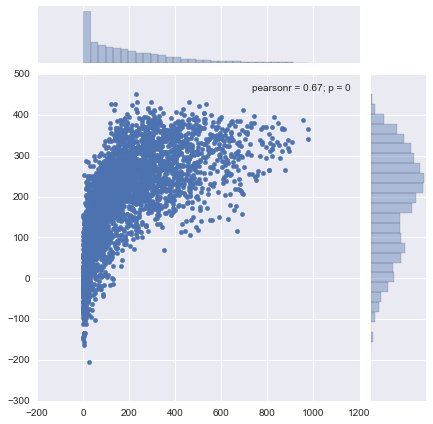

In [58]:
sns.jointplot(x=test.cnt.values, y=pred)

This graph doesn't look like the predictions are that great...

# Decision Trees
Let's take a look at the Decision Tree Regressor from scikit learn:

Let's create a function that can iterate on the parameters we want to vary.

In [59]:


params = {
    'min_samples_leaf': [3,7,13],
    'max_depth': [None,5, 10, 15],
    'min_samples_split': [15,30,50]
}

from itertools import product
d = {'Color': ['Red', 'Yellow'], 'Size': ['Small', 'Medium', 'Large']}
list_of_params = [dict(zip(params, v)) for v in product(*params.values())]
list_of_params

[{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 50},
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 50},
 {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 50},
 {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 50},
 {'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 15},
 {'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 30},
 {'max_depth': None, 'min_samples_leaf': 

Let's create a dataframe to track the results easier

In [60]:
results = pd.DataFrame(list_of_params)
results.head(5)

max_depth  min_samples_leaf  min_samples_split
0        NaN                 3                 15
1        NaN                 3                 30
2        NaN                 3                 50
3        5.0                 3                 15
4        5.0                 3                 30

Now lets use these parameters with the decision tree regressor and look at the mean squared error for the train and test data sets.

In [61]:
dt_results = []
for params in list_of_params:
    model = DecisionTreeRegressor(random_state=1, **params)
    model.fit(train[columns],train.cnt)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.cnt,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.cnt,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'dt_MSE_train': MSE_train,
        'dt_MSE_test': MSE_test,
        'dt_MSE_diff': MSE_diff
    }
    dt_results.append(d)
#     print("Case: = {0}".format(params))
#     print("   MSE_train: {0}   MSE_test: {1}  MSE_diff: {2}".\
#           format(np.round(MSE_train,decimals=2),\
#                  np.round(MSE_test,decimals=2),\
#                 np.round(MSE_diff,decimals=2)))
    

In [62]:
results = results.merge(np.round(pd.DataFrame(dt_results),decimals=1),left_index=True,right_index=True)


In [63]:
results

max_depth  min_samples_leaf  min_samples_split  dt_MSE_diff  dt_MSE_test  \
0         NaN                 3                 15      -8652.2      17529.4   
1         NaN                 3                 30      -5711.4      16497.5   
2         NaN                 3                 50      -3902.1      16008.9   
3         5.0                 3                 15        -36.3      17335.0   
4         5.0                 3                 30        -36.3      17335.0   
5         5.0                 3                 50        -36.3      17335.0   
6        10.0                 3                 15      -2401.1      15824.0   
7        10.0                 3                 30      -2049.4      15776.7   
8        10.0                 3                 50      -1801.6      15801.0   
9        15.0                 3                 15      -6375.0      16719.5   
10       15.0                 3                 30      -4401.1      16041.6   
11       15.0                 3                 50      -3174.8      15759.4   
12        NaN                 7                 15      -6842.1      16845.4   
13        NaN                 7                 30      -4962.3      16305.0   
14        NaN                 7                 50      -3662.4      16009.9   
15        5.0                 7                 15        -40.1      17339.1   
16        5.0                 7                 30        -40.1      17339.1   
17        5.0                 7                 50        -40.1      17339.1   
18       10.0                 7                 15      -2282.4      15868.7   
19       10.0                 7                 30      -2016.0      15828.6   
20       10.0                 7                 50      -1755.3      15810.2   
21       15.0                 7                 15      -5217.4      16228.5   
22       15.0                 7                 30      -4089.0      16034.0   
23       15.0                 7                 50      -3159.3      15878.9   
24        NaN                13                 15      -3946.7      15880.3   
25        NaN                13                 30      -3835.8      15931.4   
26        NaN                13                 50      -2908.2      15708.3   
27        5.0                13                 15        -40.1      17339.1   
28        5.0                13                 30        -40.1      17339.1   
29        5.0                13                 50        -40.1      17339.1   
30       10.0                13                 15      -1861.9      15772.8   
31       10.0                13                 30      -1839.2      15801.6   
32       10.0                13                 50      -1521.2      15696.3   
33       15.0                13                 15      -3472.9      15772.1   
34       15.0                13                 30      -3356.7      15787.8   
35       15.0                13                 50      -2608.2      15629.7   

    dt_MSE_train  
0         8877.2  
1        10786.1  
2        12106.8  
3        17298.7  
4        17298.7  
5        17298.7  
6        13423.0  
7        13727.4  
8        13999.5  
9        10344.5  
10       11640.5  
11       12584.6  
12       10003.3  
13       11342.7  
14       12347.5  
15       17299.0  
16       17299.0  
17       17299.0  
18       13586.3  
19       13812.6  
20       14054.9  
21       11011.1  
22       11945.0  
23       12719.6  
24       11933.6  
25       12095.6  
26       12800.1  
27       17299.0  
28       17299.0  
29       17299.0  
30       13910.9  
31       13962.4  
32       14175.1  
33       12299.1  
34       12431.1  
35       13021.6

Let's try to combine the best results:
    `min_samples_leaf = 7`
    `max_depth = 10`
    `min_samples_split = 30`

In [64]:
model = DecisionTreeRegressor(random_state=1, min_samples_split=15,max_depth=15,min_samples_leaf=7)
model.fit(train[columns],train.cnt)
#let's predict the train data and find the error
pred_train = model.predict(train[columns])
MSE_train = mean_squared_error(train.cnt,pred_train)

#lets predict the test data and find the error
pred_test = model.predict(test[columns])
MSE_test = mean_squared_error(test.cnt,pred_test)
print("   MSE_train: {0}   MSE_test: {1}".format(np.round(MSE_train,decimals=2),\
                                                 np.round(MSE_test,decimals=2)))

   MSE_train: 11011.1   MSE_test: 16228.45


Now let's look at Random Forests:

In [65]:
rf_results = []
for params in list_of_params:
    model = RandomForestRegressor(random_state=1, **params)
    model.fit(train[columns],train.cnt)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.cnt,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.cnt,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'rf_MSE_train': MSE_train,
        'rf_MSE_test': MSE_test,
        'rf_MSE_diff': MSE_diff
    }
    rf_results.append(d)

In [66]:
results = results.merge(np.round(pd.DataFrame(rf_results),decimals=1),\
                        left_index=True,right_index=True)

How does the Random forest results compare to the decision tree results?

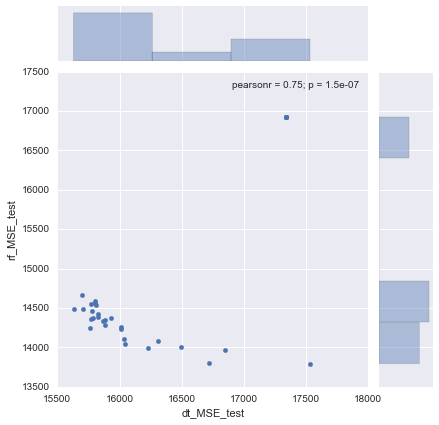

In [67]:
sns.jointplot(x=results.dt_MSE_test,y=results.rf_MSE_test)

It looks like there's some of the results which have high error. Let's see which params cause that.

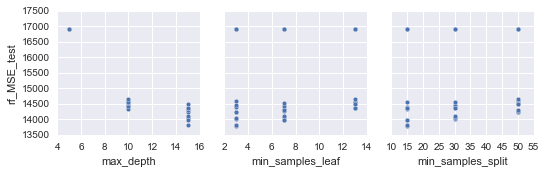

In [68]:
sns.pairplot(results,x_vars=['max_depth','min_samples_leaf',\
                             'min_samples_split'],y_vars=['rf_MSE_test'])

Yep it looks like it's due to the `max_depth` parameter. Let's take a closer look:

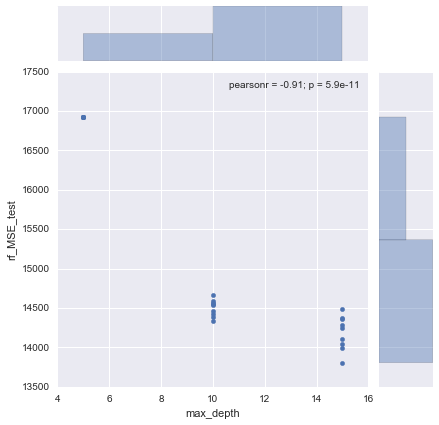

In [69]:
sns.jointplot(x='max_depth',y='rf_MSE_test',data=results)

It looks like there is a large reduction in error between `max_depth=5` and `max_depth=10`. Now that we know this, let's not use `max_depth=5`

In [70]:

params = {
    'min_samples_leaf': [3,7,13],
    'max_depth': [None,10, 15],
    'min_samples_split': [15,30,50]
}

from itertools import product
list_of_params = [dict(zip(params, v)) for v in product(*params.values())]
list_of_params

[{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 50},
 {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 50},
 {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 15},
 {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 30},
 {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 50},
 {'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 15},
 {'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 30},
 {'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 50},
 {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 15},
 {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 30},
 {'max_depth': 10, 'min_samples_leaf

## Predictions for casual riders

In [71]:
cas_results = pd.DataFrame(list_of_params)

In [72]:
rf_results = []
for params in list_of_params:
    model = RandomForestRegressor(random_state=1, **params)
    model.fit(train[columns],train.casual)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.casual,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.casual,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'rf_MSE_train': MSE_train,
        'rf_MSE_test': MSE_test,
        'rf_MSE_diff': MSE_diff
    }
    rf_results.append(d)

In [73]:
cas_results = cas_results.merge(np.round(pd.DataFrame(rf_results),decimals=1),\
                                left_index=True,right_index=True)

In [84]:
cas_results

max_depth  min_samples_leaf  min_samples_split  rf_MSE_diff  rf_MSE_test  \
0         NaN                 3                 15       -202.6        498.7   
1         NaN                 3                 30       -144.4        521.0   
2         NaN                 3                 50       -121.4        556.6   
3        10.0                 3                 15       -148.9        524.6   
4        10.0                 3                 30       -123.0        540.1   
5        10.0                 3                 50       -111.9        567.2   
6        15.0                 3                 15       -195.4        498.9   
7        15.0                 3                 30       -142.3        521.6   
8        15.0                 3                 50       -120.1        556.5   
9         NaN                 7                 15       -174.3        522.5   
10        NaN                 7                 30       -137.2        542.7   
11        NaN                 7                 50       -117.4        571.2   
12       10.0                 7                 15       -138.3        539.4   
13       10.0                 7                 30       -120.0        554.0   
14       10.0                 7                 50       -108.9        577.0   
15       15.0                 7                 15       -171.5        523.3   
16       15.0                 7                 30       -136.1        543.2   
17       15.0                 7                 50       -116.5        571.0   
18        NaN                13                 15       -131.2        564.9   
19        NaN                13                 30       -128.0        566.4   
20        NaN                13                 50       -117.6        591.4   
21       10.0                13                 15       -120.9        575.1   
22       10.0                13                 30       -118.2        576.0   
23       10.0                13                 50       -111.5        596.3   
24       15.0                13                 15       -130.2        564.9   
25       15.0                13                 30       -127.2        566.5   
26       15.0                13                 50       -117.0        591.2   

    rf_MSE_train  
0          296.0  
1          376.6  
2          435.3  
3          375.7  
4          417.1  
5          455.3  
6          303.6  
7          379.4  
8          436.5  
9          348.1  
10         405.5  
11         453.8  
12         401.2  
13         434.0  
14         468.2  
15         351.9  
16         407.1  
17         454.5  
18         433.7  
19         438.4  
20         473.8  
21         454.2  
22         457.8  
23         484.8  
24         434.7  
25         439.3  
26         474.2

## Predictions for registered riders

In [75]:
reg_results = pd.DataFrame(list_of_params)
rf_results = []
for params in list_of_params:
    model = RandomForestRegressor(random_state=1, **params)
    model.fit(train[columns],train.registered)
    #let's predict the train data and find the error
    pred_train = model.predict(train[columns])
    MSE_train = mean_squared_error(train.registered,pred_train)

    #lets predict the test data and find the error
    pred_test = model.predict(test[columns])
    MSE_test = mean_squared_error(test.registered,pred_test)
    
    MSE_diff = MSE_train - MSE_test
    
    d = {
        'rf_MSE_train': MSE_train,
        'rf_MSE_test': MSE_test,
        'rf_MSE_diff': MSE_diff
    }
    rf_results.append(d)

reg_results = reg_results.merge(np.round(pd.DataFrame(rf_results),decimals=1),left_index=True,right_index=True)

So it looks like the error for the casual riders and registered riders is smaller than the error for the overall rentals. I wonder if we can predict the casual and registered seperatly and combine the results to get better predictions than before?

First, lets look at the errors and compare them.

In [77]:
combined_MSE_test = cas_results.rf_MSE_test + reg_results.rf_MSE_test
np.mean(combined_MSE_test - results.rf_MSE_test)

-2849.6888888888884

In [78]:
model = RandomForestRegressor(random_state=1, max_depth=15,\
                                  min_samples_leaf=3, min_samples_split=15)
model.fit(train[columns],train.cnt)
#let's predict the train data and find the error
cnt_pred_train = model.predict(train[columns])
cnt_MSE_train = mean_squared_error(train.cnt,cnt_pred_train)

#lets predict the test data and find the error
cnt_pred_test = model.predict(test[columns])
cnt_MSE_test = mean_squared_error(test.cnt,cnt_pred_test)
cnt_MSE_diff = cnt_MSE_train - cnt_MSE_test
print(cnt_MSE_test)


13806.3326585


498.93967832


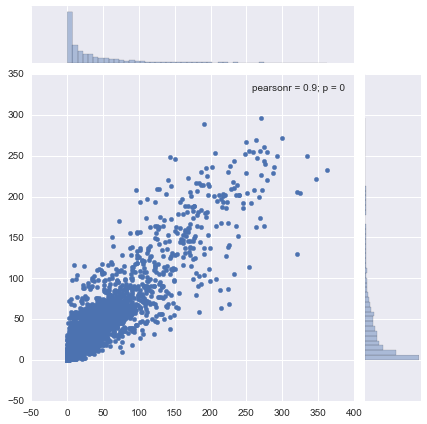

In [87]:
model = RandomForestRegressor(random_state=1, max_depth=15,\
                                  min_samples_leaf=3, min_samples_split=15)
model.fit(train[columns],train.casual)
#let's predict the train data and find the error
cas_pred_train = model.predict(train[columns])
cas_MSE_train = mean_squared_error(train.casual,cas_pred_train)

#lets predict the test data and find the error
cas_pred_test = model.predict(test[columns])
cas_MSE_test = mean_squared_error(test.casual,cas_pred_test)
cas_MSE_diff = cas_MSE_train - cas_MSE_test
print(cas_MSE_test)
sns.jointplot(x=test.casual.values,y=cas_pred_test)

11299.9689327


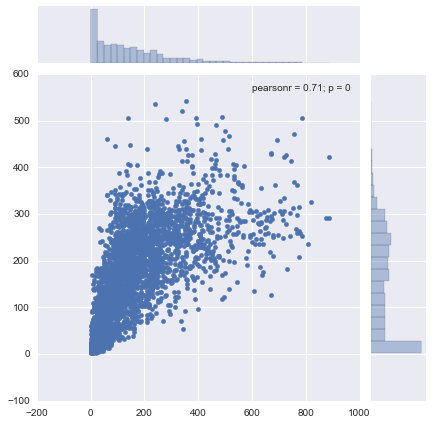

In [88]:
model = RandomForestRegressor(random_state=1, max_depth=15,\
                                  min_samples_leaf=3, min_samples_split=15)
model.fit(train[columns],train.registered)
#let's predict the train data and find the error
reg_pred_train = model.predict(train[columns])
reg_MSE_train = mean_squared_error(train.registered,reg_pred_train)

#lets predict the test data and find the error
reg_pred_test = model.predict(test[columns])
reg_MSE_test = mean_squared_error(test.registered,reg_pred_test)
reg_MSE_diff = reg_MSE_train - reg_MSE_test
print(reg_MSE_test)
sns.jointplot(x=test.registered.values, y=reg_pred_test)

In [81]:
comb_pred_test = cas_pred_test + reg_pred_test
comb_MSE_test = mean_squared_error(test.cnt,comb_pred_test)
print("Combined error: {0}".format(comb_MSE_test))
print("Regular error: {0}".format(cnt_MSE_test))

Combined error: 13610.480698082898
Regular error: 13806.332658450678


So it looks like creating two separate predictions and combining them does reduce the error!

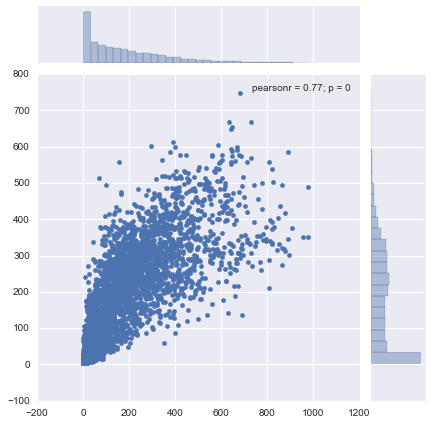

In [82]:
sns.jointplot(x=test.cnt.values, y=comb_pred_test)